In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import QuantLib as ql

from scipy.integrate import quad
from scipy.special import iv

In [2]:
# QL Pricing Setup
today = ql.Date(1, 12, 2020)
day_count = ql.Actual365Fixed()
calendar = ql.NullCalendar()

spot = 100
rate, dividend = 0.0, 0.0

# Heston process parameters
vol = 0.3
v0 = vol * vol
kappa = 1.15
theta = 0.0348
rho = -0.64
sigma = 0.39

# Set up the vol and risk-free curves
spot_quote = ql.QuoteHandle(ql.SimpleQuote(spot))
riskFreeCurve = ql.FlatForward(today, rate, day_count)
dividendCurve = ql.FlatForward(today, dividend, day_count)
flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
dividend_ts = ql.YieldTermStructureHandle(dividendCurve)

# Set up the Heston Process/Analytic Pricer
heston_process = ql.HestonProcess(flat_ts, dividend_ts, spot_quote, v0, kappa, theta, sigma, rho)
heston_model = ql.HestonModel(heston_process)
heston_engine = ql.AnalyticHestonEngine(heston_model)

# Option Contract Parameters
expiry_date = ql.Date(1, 12, 2021)
T = day_count.yearFraction(today, expiry_date)
K = 100
k = np.log(K/spot)
dcf = flat_ts.discount(T)

payoff = ql.PlainVanillaPayoff(ql.Option.Call, K)
european_exercise = ql.EuropeanExercise(expiry_date)

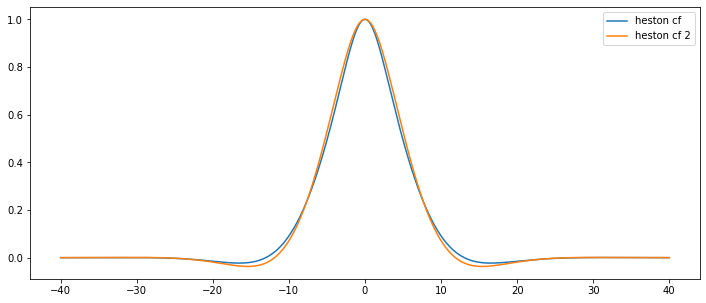

In [3]:
# Heston Engine provides the Characeteristic Function, let's have a look...
vals = np.linspace(-40, 40, 1000)

plt.figure(figsize=(12,5))

plt.plot(vals, [heston_engine.chF(x,0,1)[0] for x in vals], label='heston cf')
plt.plot(vals, [heston_engine.chF(x,-1,1)[0] for x in vals], label='heston cf 2')

plt.legend()

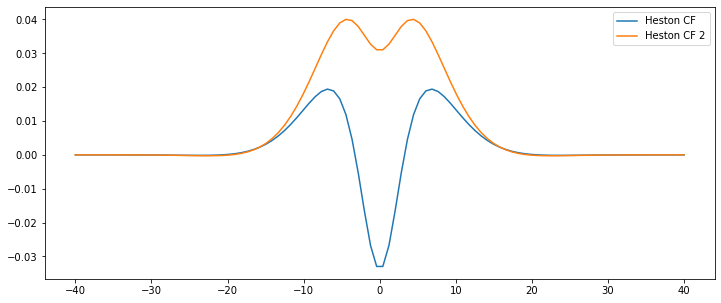

In [4]:
# And how will this look when turned into the integrand for P1 and P2?
def cf(x, t=1):
    re = np.real(x)
    im = np.imag(x)
    x, y = heston_engine.chF(re,im,t)
    return x + 1j*y

x = np.linspace(-40, 40, 100)

plt.figure(figsize=(12,5))
plt.plot(x, [np.real(np.exp(-u*k*1j) /(u*1j) * cf(u)) for u in x], label="Heston CF" )
plt.plot(x, [np.real((np.exp(-u*k*1j) / (u*1j)) * cf(u-1j)) for u in x], label="Heston CF 2" )

plt.legend()

In [5]:
# Test manually pricing by integration, vs. QuantLib calculation
integrand = lambda u: np.real((np.exp(-u*k*1j) / (u*1j)) * cf(u-1j))
integrand_2 = lambda u: np.real(np.exp(-u*k*1j) /(u*1j) * cf(u))

right_lim = 1000

P_1 = 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000)[0]
P_2 = 1/2 + 1/np.pi * quad(integrand_2, 1e-15, right_lim, limit=2000)[0]

analy_call = spot * P_1 - K * dcf * P_2

vanilla_option = ql.VanillaOption(payoff, european_exercise)
vanilla_option.setPricingEngine(heston_engine)
ql_call = vanilla_option.NPV()

analy_call, ql_call

(9.609183165210496, 9.609183165210446)

In [ ]:
# Now setting up the machinery to price forward options

In [6]:
# The propagator function from v0 to vt (nb. involves Bessel function)
def greens_func(v, t_star, t=0.0):
    kappa_hat = kappa - rho*sigma
    theta_hat = kappa*theta / (kappa - rho*sigma)

    B = 4*kappa_hat/ ((1-np.exp(-kappa_hat*(t_star-t))) * sigma**2)
    R = 4*kappa_hat * theta_hat / sigma**2
    Lambda = B * np.exp(-kappa_hat * (t_star-t))*v0

    term_1 = 0.5 * B * np.exp(-(B*v+Lambda)/2)
    term_2 = pow((B*v/Lambda), 0.5*(0.5*R - 1))
    term_3 = iv(0.5*R - 1,np.sqrt(Lambda*B*v))

    return term_1 * term_2 * term_3

# Utility function to return arbitrary CF for t, vt, St using ql... might not be most efficient way!
def get_cf(tenor, spot0, var0, kappa=kappa, theta=theta, rho=rho, sigma=sigma, rate=rate, dividend=dividend):
    day_count = ql.Actual365Fixed()
    calendar = ql.NullCalendar()

    spot_quote = ql.QuoteHandle(ql.SimpleQuote(spot0))
    riskFreeCurve = ql.FlatForward(today, rate, day_count)
    dividendCurve = ql.FlatForward(today, dividend, day_count)
    flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
    dividend_ts = ql.YieldTermStructureHandle(dividendCurve)

    heston_process = ql.HestonProcess(flat_ts, dividend_ts, spot_quote, var0, kappa, theta, sigma, rho)
    heston_model = ql.HestonModel(heston_process)
    heston_engine = ql.AnalyticHestonEngine(heston_model)

    def cf(x):
        x, y = heston_engine.chF(np.real(x),np.imag(x),tenor)
        return x + 1j*y

    return cf

In [7]:
# Function to calculate P1 and P2, for Heston these are analagous to Phi(d1) and Phi(d2) terms in BSM

def P1(t, spot, var, strike, right_lim=1000):
    tenor = T - t
    cf = get_cf(tenor, spot, var)
    k = np.log(strike/spot)
    integrand = lambda u: np.real((np.exp(-u*k*1j) / (u*1j)) * cf(u-1j))
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000)[0]

def P2(t, spot, var, strike, right_lim=1000):
    tenor = T - t
    cf = get_cf(tenor, spot, var)
    k = np.log(strike/spot)
    integrand = lambda u: np.real(np.exp(-u*k*1j) /(u*1j) * cf(u))
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000)[0]

In [8]:
P1(0.05, 1, 0.09, 1.05), P2(0.05, 1, 0.09, 1.05)

(0.5313461247564493, 0.4390769589015509)

In [9]:
# For fwd-start options, we integrate the product of the propagator and the
# resulting CF to obtain 'P1_hat' and 'P2_hat' which replace P1 and P2 in
# the pricing expression

def P1_hat(t_star, moneyness, var_lim=2.0):
    integrand = lambda u: P1(t_star, 1, u, moneyness) * greens_func(u, t_star)
    return quad(integrand, 1e-15, var_lim, limit=2000)[0]

def P2_hat(t_star, moneyness, var_lim=2.0):
    integrand = lambda u: P2(t_star, 1, u, moneyness) * greens_func(u, t_star)
    return quad(integrand, 1e-15, var_lim, limit=2000)[0]

def forward_price(t_star, moneyness, dcf):
    term_1 = P1_hat(t_star, moneyness)
    term_2 = P2_hat(t_star, moneyness)

    return spot * term_1 - moneyness * spot * dcf * term_2

In [11]:
# Price a selection of reset dates and moneynesses, analytically
t_stars = np.linspace(0.05, 0.95, 19)
moneynesses = [0.95, 1.0, 1.05]
results = {}

for moneyness in moneynesses:
    results["analy_{}".format(moneyness)] = [forward_price(x, moneyness, dcf) for x in t_stars]

results_df = pd.DataFrame(results, index=t_stars)

In [12]:
# Price the same options using the Heston MC pricer in QL (nb. requires v1.21-dev)
timeSteps, requiredSamples = 24, 2**17
engine = ql.MCForwardEuropeanHestonEngine(heston_process, "LD", timeSteps=timeSteps, requiredSamples=requiredSamples)

def ql_price(t_start, moneyness):
    reset_date = today + ql.Period(int(365*t_start), ql.Days)
    forward_start_option = ql.ForwardVanillaOption(moneyness, reset_date, payoff, european_exercise)

    forward_start_option.setPricingEngine(engine)
    return forward_start_option.NPV()

for moneyness in moneynesses:
    ql_prices = [ql_price(x, moneyness) for x in t_stars]
    results_df["qlmc_{}".format(moneyness)] = ql_prices

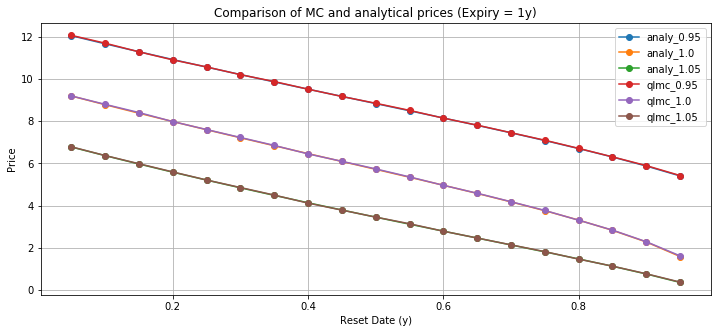

In [13]:
# Compare prices graphically
results_df.plot(marker='o', figsize=(12,5))

plt.title("Comparison of MC and analytical prices (Expiry = 1y)")
plt.xlabel("Reset Date (y)")
plt.ylabel("Price")

plt.grid()

In [14]:
results_df

,analy_0.95,analy_1.0,analy_1.05,qlmc_0.95,qlmc_1.0,qlmc_1.05
0.05,12.043729,9.186953,6.770967,12.060435,9.191458,6.781456
0.10,11.658627,8.774756,6.361921,11.689197,8.790773,6.368144
0.15,11.282890,8.371803,5.964970,11.279429,8.402747,5.978799
0.20,10.915642,7.977161,5.579292,10.897150,7.975402,5.590968
0.25,10.555899,7.589755,5.203967,10.564411,7.598118,5.208745
0.30,10.202579,7.208376,4.838032,10.198436,7.222290,4.851828
0.35,9.854516,6.831684,4.480517,9.871529,6.847084,4.494483
0.40,9.510460,6.458203,4.130469,9.510365,6.444119,4.113325
0.45,9.169064,6.086293,3.786952,9.165243,6.093975,3.782667
0.50,8.828865,5.714107,3.449041,8.843456,5.733967,3.451155
